In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Files in folder: ['Data_Train.xlsx', 'Sample_submission.xlsx', 'Test_set.xlsx']
Training Data:


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


Test Data:


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
✅ Dataset Loaded Successfully
(10683, 11)

Missing Values Before Cleaning:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stop

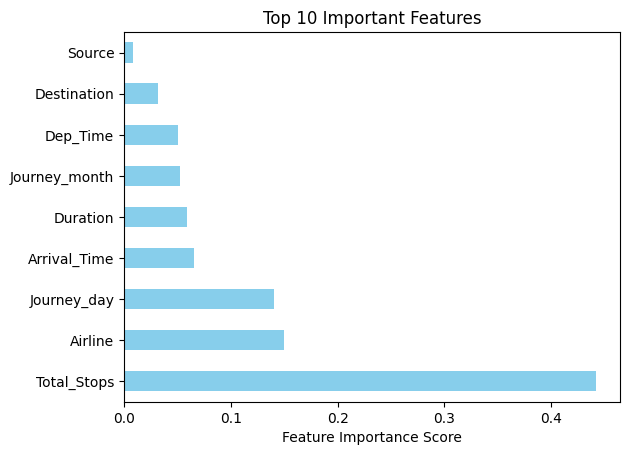

5-Fold CV MAE scores: [1181.71903927 1165.36886807 1254.79265147 1211.09864078 1256.71846699]
5-Fold CV MAE (mean ± std): 1213.94 ± 37.16
Test MAE: 1193.82
Test R2: 0.826

Summary:
- CV MAE (mean ± std): 1213.94 ± 37.16
- Test MAE: 1193.82


In [2]:
# Step 1️⃣ - Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 2️⃣ - Load the dataset
folder_path = "/kaggle/input/flight-fare"
print("Files in folder:", os.listdir(folder_path))

train_df = pd.read_excel(f"{folder_path}/Data_Train.xlsx")
test_df = pd.read_excel(f"{folder_path}/Test_set.xlsx")

# Display first few rows
print("Training Data:")
display(train_df.head())

print("Test Data:")
display(test_df.head())

# Basic info
train_df.info()
train_df.describe()
train_df.isnull().sum()

print("✅ Dataset Loaded Successfully")
print(train_df.shape)
train_df.head()

# Step 3️⃣ - Check for missing values
print("\nMissing Values Before Cleaning:")
print(train_df.isnull().sum())

# Step 4️⃣ - Fill missing values automatically
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].mean())

categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
   train_df.loc[:, col] = train_df[col].fillna(train_df[col].mode()[0])


print("\nMissing Values After Cleaning:")
print(train_df.isnull().sum())

# Step 5️⃣ - Feature Engineering (extracting date info)
train_df['Date_of_Journey'] = pd.to_datetime(train_df['Date_of_Journey'], format='%d/%m/%Y')
train_df['Date_of_Journey'] = pd.to_datetime(train_df['Date_of_Journey'])
train_df['Journey_day'] = train_df['Date_of_Journey'].dt.day
train_df['Journey_month'] = train_df['Date_of_Journey'].dt.month
train_df.drop(['Date_of_Journey'], axis=1, inplace=True)

# Step 6️⃣ - Drop unwanted columns
train_df.drop(['Route', 'Additional_Info'], axis=1, inplace=True, errors='ignore')

# Step 7️⃣ - Encode categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    train_df[col] = le.fit_transform(train_df[col])

print("\n✅ Encoding Completed")

# Step 8️⃣ - Split data into features and target
X = train_df.drop('Price', axis=1)
y = train_df['Price']

# Step 9️⃣ - Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 🔟 - Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 1️⃣1️⃣ - Predict and evaluate
y_pred = model.predict(X_test)

print("\n📈 Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# Step 1️⃣2️⃣ - Feature Importance Visualization
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance Score")
plt.show()

# Step 0: imports (add/ensure these are present)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ---------- Step 1: (If not already done) ensure X and y are ready ----------
# Example (uncomment if you need to recreate split)
# X = train_df.drop('Price', axis=1)
# y = train_df['Price']

# ---------- Step 2: Train/test split (if not already split) ----------
# If you already have X_train, X_test, y_train, y_test, skip this block.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ---------- Step 3: Define model ----------
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# ---------- Step 4: K-Fold cross-validation (k=5) ----------
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# cross_val_score returns array of scores; for MAE we use neg_mean_absolute_error
cv_scores_neg = cross_val_score(
    model,
    X_train,
    y_train,
    scoring='neg_mean_absolute_error',
    cv=kf,
    n_jobs=-1,
    verbose=0
)

# Convert to positive MAE values
cv_mae_scores = -cv_scores_neg
cv_mae_mean = np.mean(cv_mae_scores)
cv_mae_std = np.std(cv_mae_scores)

print(f"{k}-Fold CV MAE scores: {cv_mae_scores}")
print(f"{k}-Fold CV MAE (mean ± std): {cv_mae_mean:.2f} ± {cv_mae_std:.2f}")

# ---------- Step 5: Fit on full training set and evaluate on test set ----------
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2  = r2_score(y_test, y_pred_test)

print(f"Test MAE: {test_mae:.2f}")
print(f"Test R2: {test_r2:.3f}")

# ---------- Optional: show comparison ----------
print("\nSummary:")
print(f"- CV MAE (mean ± std): {cv_mae_mean:.2f} ± {cv_mae_std:.2f}")
print(f"- Test MAE: {test_mae:.2f}")
